# Final Project for Module 1

## Possible avenues for investigation:

Possible correlations to investigate using *first three* databases:

- Gross vs. genre

- Gross vs. length
 
- Gross vs. year

- Gross vs. rating

- Rating vs. genre

- Rating vs. length

Considerations

- If there are really old movies, perhaps exclude them as they're less relevant to the market today

- Look at profit not just gross

### Note on budget metrics

Use The Numbers not Box Office Mojo -- they are more precise and more accurate.

Import packages that will be used throughout project

In [72]:
##### IMPORT ALL PACKAGES #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf

##### BASIC DECLARATIONS #####
%matplotlib inline
pysqldf = lambda q: sqldf(q, globals())

Upload all available data to Pandas dataframes

In [69]:
##### IMPORT ALL DATA #####
df_imdb_name_basics = pd.read_csv('data/imdb.name.basics.csv')
df_imdb_title_akas = pd.read_csv('data/imdb.title.akas.csv')
df_imdb_title_basics = pd.read_csv('data/imdb.title.basics.csv') # PRIMARY
df_imdb_title_crew = pd.read_csv('data/imdb.title.crew.csv')
df_imdb_title_principals = pd.read_csv('data/imdb.title.principals.csv')
df_imdb_title_ratings = pd.read_csv('data/imdb.title.ratings.csv') # PRIMARY
df_rt_movie_info = pd.read_csv('data/rt.movie_info.tsv', delimiter = '\t')
df_rt_reviews = pd.read_csv('data/rt.reviews.tsv', delimiter = '\t', encoding= 'unicode_escape')
df_tmdb_movies = pd.read_csv('data/tmdb.movies.csv').drop('Unnamed: 0', axis=1)
df_tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

# Create Dataframe containing financial data

In [5]:
##### COMBINE AND CLEAN FINANCIAL DATA #####

#create dataframe
df_money = df_tn_movie_budgets.loc[:, ['movie', 'production_budget', 'domestic_gross','worldwide_gross']].copy()

#clean data
production_budget = [float(x.replace('$', '').replace(',','')) for x in df_money.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.worldwide_gross]

#relabel
df_money = pd.DataFrame([production_budget, domestic_gross, worldwide_gross]).transpose()
df_money.columns = ['production_budget', 'domestic_gross', 'worldwide_gross']

#calculate profit
df_money['profit'] = df_money.worldwide_gross - df_money.production_budget

#rearrange and relabel
df_money['movie'] = df_tn_movie_budgets.movie
df_money = df_money[['movie','production_budget', 'domestic_gross', 'worldwide_gross', 'profit']]
df_money = df_money.sort_values(by='movie').reset_index(drop=True)

df_money.head(3)

,movie,production_budget,domestic_gross,worldwide_gross,profit
0,#Horror,1500000.0,0.0,0.0,-1500000.0
1,(500) Days of Summer,7500000.0,32425665.0,34439060.0,26939060.0
2,10 Cloverfield Lane,5000000.0,72082999.0,108286422.0,103286422.0


## Create list of all genres

In [6]:
##### LIST ALL GENRES FROM *LISTS IN DATAFRAME CELLS* #####
# this will be used to clean genre data

genres_messy = df_imdb_title_basics.loc[df_imdb_title_basics['genres'].isna() == False]['genres'].unique()
genres_clean = []

for genre in genres_messy:
    for sublist in genre.split(','):
        genres_clean.append(sublist)
    
genres_clean = list(set(genres_clean))
genres_clean = pd.DataFrame(genres_clean).sort_values(0).iloc[:,0].tolist()

### Create dataframe with all genre data

In [7]:
##### NEW DATAFRAME TO CONTAIN BINARY GENRE DATA #####

df_genres = df_imdb_title_basics[df_imdb_title_basics['genres'].isna() == False].copy()
df_genres.reset_index(drop=True, inplace=True)

for category in genres_clean:
    df_genres[category] = [category in x for x in df_genres['genres']]

df_genres.drop(['start_year', 'runtime_minutes', 'genres', 'original_title'], axis=1, inplace=True)
df_genres.head(3)

,tconst,primary_title,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,tt0063540,Sunghursh,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,tt0066787,One Day Before the Rainy Season,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,tt0069049,The Other Side of the Wind,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


------------------------------------------------------

## Create Dataframe containing EVERYTHING so far

In [8]:
q = '''
SELECT *
FROM df_imdb_title_basics basics
LEFT JOIN df_genres genres
USING (tconst)
LEFT JOIN df_money money
ON basics.primary_title == money.movie
LEFT JOIN df_tmdb_movies tmdb
ON basics.primary_title == tmdb.original_title
;'''

df_complete = pysqldf(q)

#rearrange
df_complete = df_complete[[
       'tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 
       'production_budget', 'domestic_gross', 'worldwide_gross', 'profit',
       'genre_ids', 'id', 'original_language', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count',
       'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']]

#label duplicate columns for deletion
df_complete.columns = ['tconst', 'primary_title', 'DELETE1', 'original_title',
       'DELETE2', 'start_year', 'runtime_minutes', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'profit', 'genre_ids', 'id_tmdb',
       'original_language', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'genre_action', 'genre_adult', 'genre_adventure',
       'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
       'genre_family', 'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror', 'genre_music',
       'genre_musical', 'genre_mystery', 'genre_news', 'genre_reality_tv', 'genre_romance', 'genre_sci_fi',
       'genre_short', 'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war', 'genre_western']

#delete duplicate/unnecessary columns
df_complete.drop(['DELETE1', 'DELETE2'], axis=1, inplace=True)

In [9]:
#df_complete.head()
#df_complete.info()
df_complete.columns

Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'profit', 'genre_ids', 'id_tmdb',
       'original_language', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'genre_action', 'genre_adult',
       'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family',
       'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror',
       'genre_music', 'genre_musical', 'genre_mystery', 'genre_news',
       'genre_reality_tv', 'genre_romance', 'genre_sci_fi', 'genre_short',
       'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war',
       'genre_western'],
      dtype='object')

In [10]:
#list columns containing genre data
GENRES_FULL = [
       'genre_action', 'genre_adult',
       'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family',
       'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror',
       'genre_music', 'genre_musical', 'genre_mystery', 'genre_news',
       'genre_reality_tv', 'genre_romance', 'genre_sci_fi', 'genre_short',
       'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war',
       'genre_western']

#declare dictionaries to be filled
profit_mean = {}
profit_median = {}

#calculate the mean and median profit fore each genre
for g in GENRES_FULL:
    profit = df_complete.loc[
                        (df_complete[g].isna() == False) &
                        (df_complete.profit.isna() == False) &
                        (df_complete[g] == True), 
                        'profit']
    if str(profit.mean()) != 'nan':
        profit_median[g[6:]] = round(profit.median(), 2)
        profit_mean  [g[6:]] = round(profit.mean(), 2)

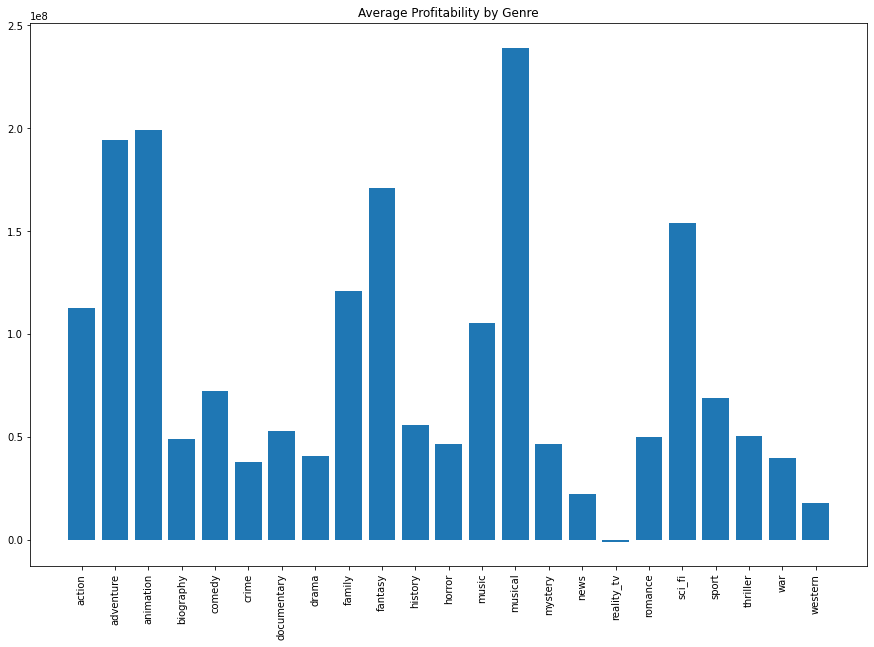

In [11]:
plt.figure(figsize=(15,10))
plt.bar(list(profit_mean.keys()), list(profit_mean.values()))
plt.xticks(rotation=90)
plt.title('Average Profitability by Genre')
plt.show()

-
-
-
-
-
-
-
-
-
-
-

# Popularity

### It's about creating a name for the company, not just immediate profitability

In [12]:
df_complete.columns

Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'profit', 'genre_ids', 'id_tmdb',
       'original_language', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'genre_action', 'genre_adult',
       'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family',
       'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror',
       'genre_music', 'genre_musical', 'genre_mystery', 'genre_news',
       'genre_reality_tv', 'genre_romance', 'genre_sci_fi', 'genre_short',
       'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war',
       'genre_western'],
      dtype='object')

In [13]:
##### CREATE TEMPLATE (almost function) FOR MEAN AND MEDIAN CALCS #####

CATEGORY = 'profit'

#loop through full database, aggregating data by genre
mean = {}
median = {}
for g in GENRES_FULL:
    temp = df_complete.loc[
                        (df_complete[g].isna() == False) &
                        (df_complete[CATEGORY].isna() == False) &
                        (df_complete[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
        mean  [g[6:]] = round(temp.mean(), 2)

#convert dictionary to dataframe
df_mean = pd.DataFrame(mean.items())
df_median = pd.DataFrame(median.items())
df_mean.columns = ['genre', CATEGORY]
df_median.columns = ['genre', CATEGORY]

#sort
df_mean.sort_values(by=CATEGORY, ascending = False, inplace = True)
df_median.sort_values(by=CATEGORY, ascending = False, inplace = True)

#reindex
df_mean.reset_index(inplace=True, drop=True)
df_median.reset_index(inplace=True, drop=True) 

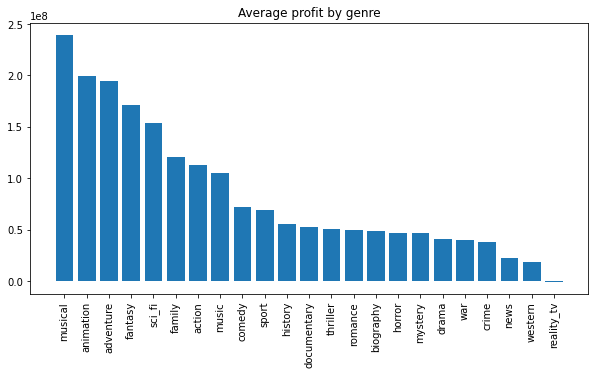

In [14]:
#### PLOT DATA FROM PRECEDING CELL #####
plt.figure(figsize=(10,5))
plt.bar(df_mean.genre, df_mean[CATEGORY])
plt.xticks(rotation=90)
plt.title('Average {} by genre'.format(CATEGORY))
plt.show()

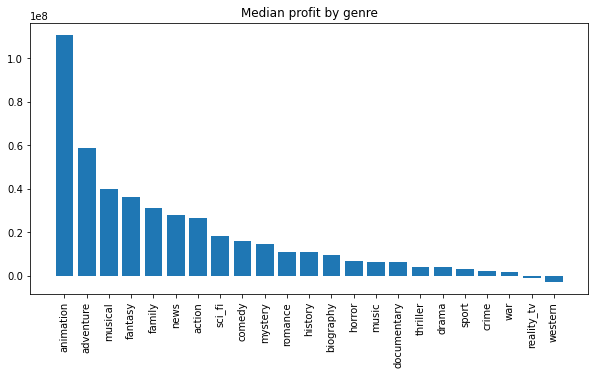

In [15]:
plt.figure(figsize=(10,5))
plt.bar(df_median.genre, df_median[CATEGORY])
plt.xticks(rotation=90)
plt.title('Median {} by genre'.format(CATEGORY))
plt.show()

In [17]:
##### CREATE DATAFRAME FOR PERCENTILE RANKINGS OF PROFIT AND POPULARITY #####

df_genre = pd.DataFrame(GENRES_FULL, GENRES_FULL)
df_genre.columns = ['genre']
    
    
####### PROFIT #######
median = []
for g in GENRES_FULL:
    temp = df_complete.loc[(df_complete[g].isna() == False) & (df_complete[CATEGORY].isna() == False) &
                           (df_complete[g] == True), 'profit']
    if str(temp.mean()) != 'nan':
        median.append(round(temp.median(), 2))
    else:
        median.append(0.0)
df_genre['profit_median'] = median


####### POPULARITY #######
median = []
for g in GENRES_FULL:
    temp = df_complete.loc[(df_complete[g].isna() == False) & (df_complete[CATEGORY].isna() == False) &
                           (df_complete[g] == True), 'popularity']
    if str(temp.mean()) != 'nan':
        median.append(round(temp.median(), 2))
    else:
        median.append(0.0)

df_genre['popularity_median'] = median

df_genre

,genre,profit_median,popularity_median
genre_action,genre_action,26800758.0,12.44
genre_adult,genre_adult,0.0,0.00
genre_adventure,genre_adventure,58702781.5,14.53
genre_animation,genre_animation,110724600.0,11.39
genre_biography,genre_biography,9403192.0,8.71
genre_comedy,genre_comedy,15852177.0,9.27
genre_crime,genre_crime,2434356.0,9.57
genre_documentary,genre_documentary,6524293.0,1.25
genre_drama,genre_drama,4152584.0,7.57
genre_family,genre_family,31059560.0,7.19


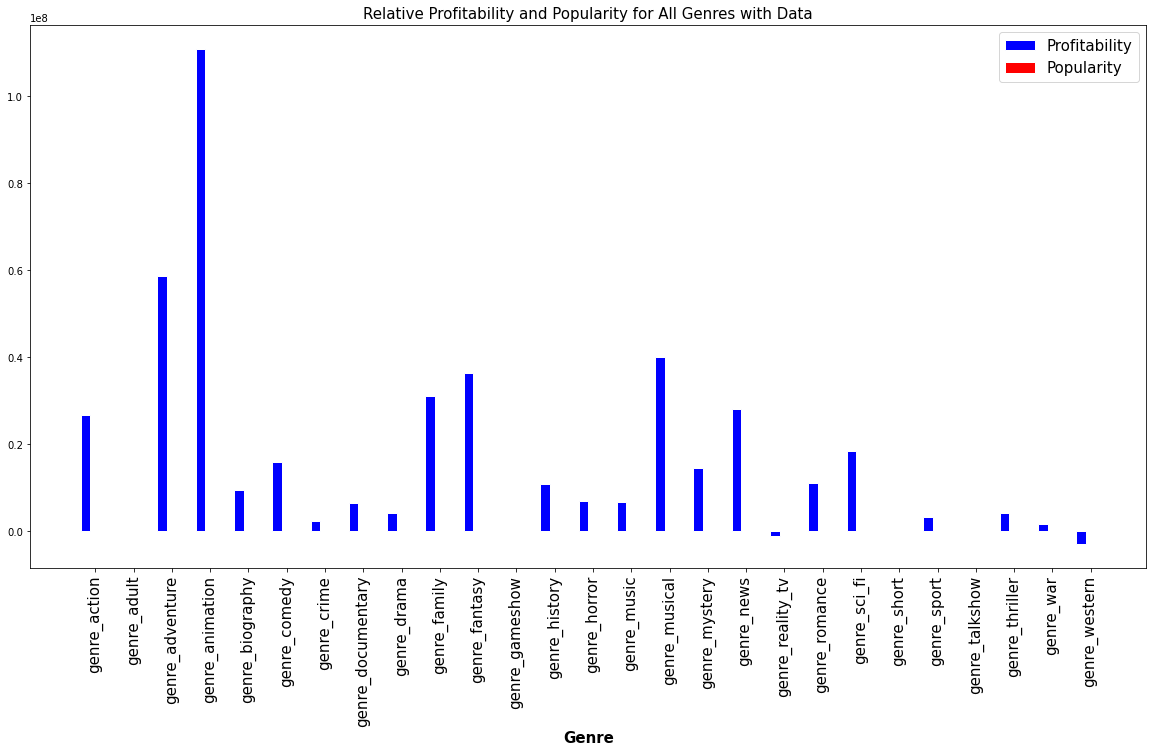

In [18]:
##### PLOT PROFITABILITY RANKING AND POPULARITY RANKING SIDE BY SIDE ##### 

plt.rcParams["figure.figsize"] = (20,10)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = df_genre['profit_median']
bars2 = df_genre['popularity_median']
x = df_genre['genre']
 
# Set position of bar on X axis
r1 = np.arange(len(x))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='white', label='var2')
 
# Add xticks on the middle of the group bars
plt.xlabel('Genre', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(bars1))], x, rotation=90, fontsize=15)
 
# Create legend & Show graphic
plt.legend(['Profitability','Popularity'], fontsize=15)
plt.title('Relative Profitability and Popularity for All Genres with Data', fontsize=15)
plt.show()

In [19]:
df_genre 

,genre,profit_median,popularity_median
genre_action,genre_action,26800758.0,12.44
genre_adult,genre_adult,0.0,0.00
genre_adventure,genre_adventure,58702781.5,14.53
genre_animation,genre_animation,110724600.0,11.39
genre_biography,genre_biography,9403192.0,8.71
genre_comedy,genre_comedy,15852177.0,9.27
genre_crime,genre_crime,2434356.0,9.57
genre_documentary,genre_documentary,6524293.0,1.25
genre_drama,genre_drama,4152584.0,7.57
genre_family,genre_family,31059560.0,7.19


In [20]:
##### IDENTIFY UNPOPULAR GENRES AND REMOVE FROM ANALYSIS #####
low_popularity = ['genre_adult', 'genre_gameshow', 'genre_war', 'genre_talkshow', 'genre_documentary', 'genre_short']
df_popular = df_genre.drop(low_popularity)
df_popular.sort_values(by='profit_median', inplace=True, ascending=False)

df_popular

,genre,profit_median,popularity_median
genre_animation,genre_animation,110724600.0,11.39
genre_adventure,genre_adventure,58702781.5,14.53
genre_musical,genre_musical,40113733.0,13.42
genre_fantasy,genre_fantasy,36246127.5,13.27
genre_family,genre_family,31059560.0,7.19
genre_news,genre_news,28031715.0,8.70
genre_action,genre_action,26800758.0,12.44
genre_sci_fi,genre_sci_fi,18341932.0,10.68
genre_comedy,genre_comedy,15852177.0,9.27
genre_mystery,genre_mystery,14610760.0,8.96


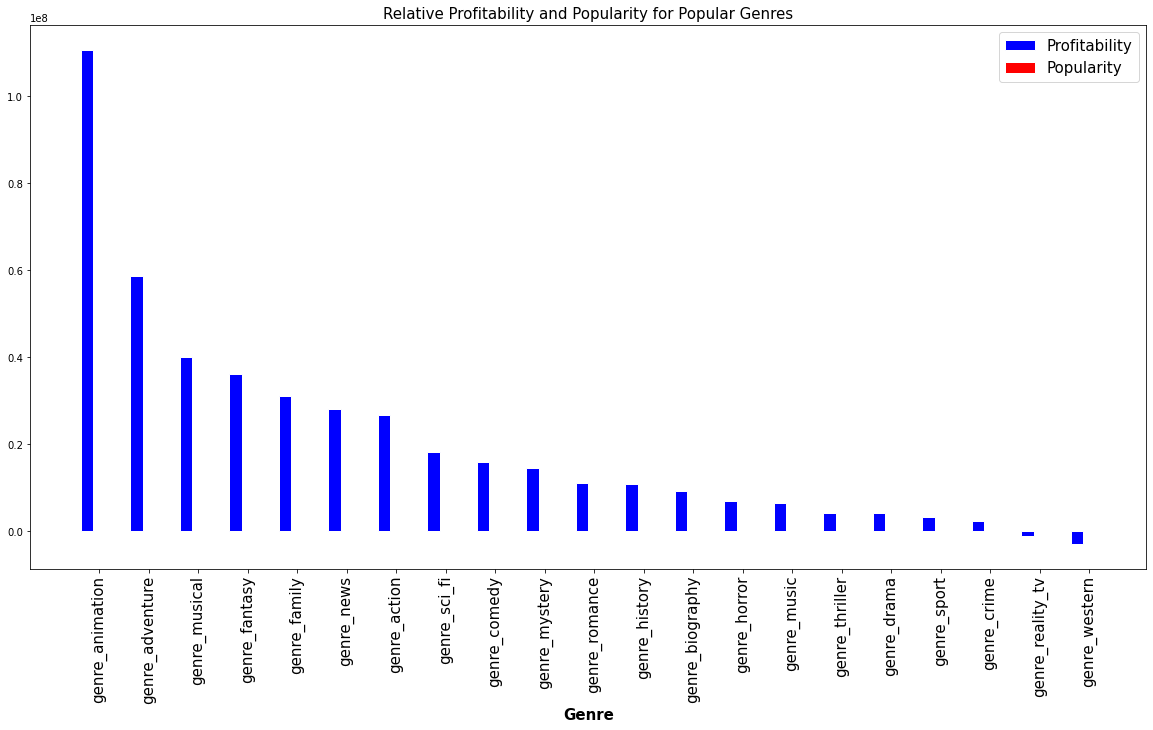

In [21]:
##### PLOT THE NEW DATASET AFTER DROPPING UNPOPULAR GENRES #####

bars1 = df_popular['profit_median']
bars2 = df_popular['popularity_median']
x = df_popular['genre']
 
# Set position of bar on X axis
r1 = np.arange(len(x))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='white', label='var2')
 
# Add xticks on the middle of the group bars
plt.xlabel('Genre', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(bars1))], x, rotation=90, fontsize=15)
 
# Create legend & Show graphic
plt.legend(['Profitability','Popularity'], fontsize=15)
plt.title('Relative Profitability and Popularity for Popular Genres', fontsize=15)
plt.show()

In [22]:
##### IDENTIFY LOW PROFIT GENRES AND DROP FROM ANALYSIS #####

low_profit = ['genre_crime', 'genre_reality_tv', 'genre_western', 'genre_sport', 'genre_drama', 'genre_thriller']
df_popular_profitable = df_popular.drop(low_profit)
df_popular_profitable

,genre,profit_median,popularity_median
genre_animation,genre_animation,110724600.0,11.39
genre_adventure,genre_adventure,58702781.5,14.53
genre_musical,genre_musical,40113733.0,13.42
genre_fantasy,genre_fantasy,36246127.5,13.27
genre_family,genre_family,31059560.0,7.19
genre_news,genre_news,28031715.0,8.70
genre_action,genre_action,26800758.0,12.44
genre_sci_fi,genre_sci_fi,18341932.0,10.68
genre_comedy,genre_comedy,15852177.0,9.27
genre_mystery,genre_mystery,14610760.0,8.96


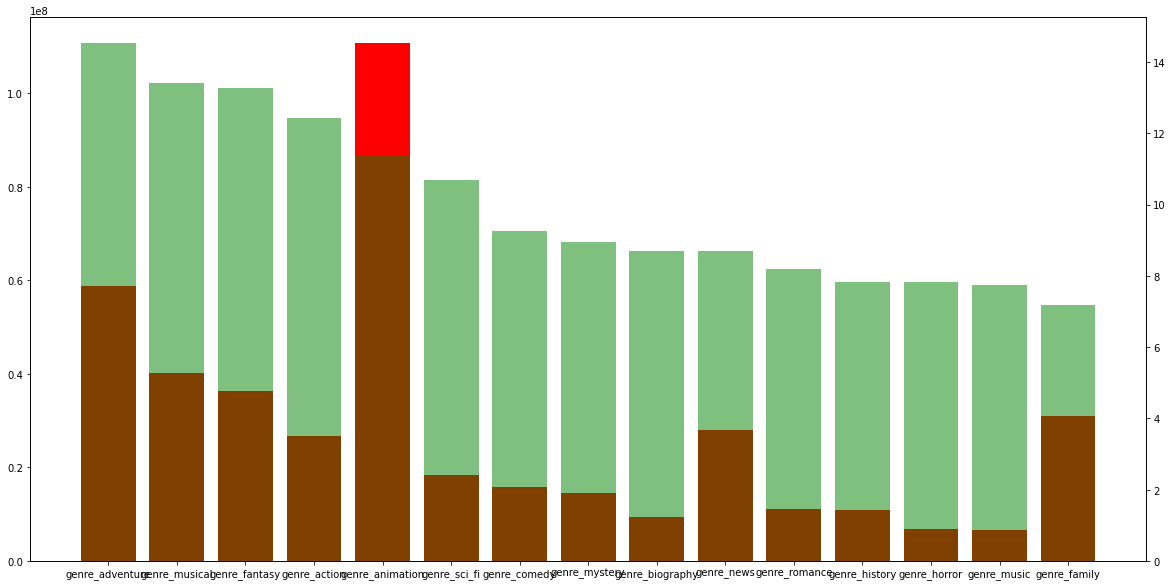

In [23]:
df_popular_profitable.sort_values(by='popularity_median', inplace=True, ascending=False)

bars1 = df_popular_profitable['profit_median']
bars2 = df_popular_profitable['popularity_median']
x = df_popular_profitable['genre']
 
# Set position of bar on X axis
#r1 = np.arange(len(x))
#r2 = [x + barWidth for x in r1]





fig, ax1 = plt.subplots()
ax1.bar(x, bars1, color='r')#list(profit_mean.keys()), list(profit_mean.values()))


ax2 = ax1.twinx() 
ax2.bar(x, bars2,color='g',alpha=0.5)#list(profit_mean.keys()), list(profit_mean.values()))
#ax1.xticks(rotation=90)
#ax1.title('Average Profitability by Genre')
plt.show()

In [67]:
##### PLOT THE NEW DATASET AFTER DROPPING UNPOPULAR AND LOW PROFITABILITY GENRES #####

df_popular_profitable.sort_values(by='popularity_median', inplace=True, ascending=False)

bars1 = df_popular_profitable['profit_median']
bars2 = df_popular_profitable['popularity_median']
x = df_popular_profitable['genre']
 
# Set position of bar on X axis
r1 = np.arange(len(x))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='white', label='var2')
 
# Add xticks on the middle of the group bars
plt.xlabel('Genre', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(bars1))], x, rotation=90, fontsize=15)
 
    
ax2 = ax1.twinx()
    
# Create legend & Show graphic
plt.legend(['Profitability','Popularity'], fontsize=15)
plt.title('Relative Profitability and Popularity for Profitable and Popular Genres', fontsize=15)
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'hbar'

# Notes From Call with Joel

- Consider frequency that each genre is produced. 

- Is there anything in this data that says starting with high popularity could lead to later profitability?

- If popularity is so vital, need to define more clearly how that is narrowed. Then, take a look at the most popular movies; profile these aspects to see "what works" and what doesn't

- Consider budgets too since that is especially relevant to companies breaking into a market

- Anything from Runtime?

- Look into top actors -- this could be something they would "need" to have in new films

- Try to create distinction between that the popular and unpopular factors are

- Tell them "what they should care about, and what they shouldn't care about". Second point is less necessary, but can be helpful

- Popular includes number of films produced in that genre, not just ratings

- Also look at distributions of this data, not just median. The company will also care about the confidence interval for these calculations.

In [25]:
genre_columns = [
       'genre_action', 'genre_adult',
       'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family',
       'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror',
       'genre_music', 'genre_musical', 'genre_mystery', 'genre_news',
       'genre_reality_tv', 'genre_romance', 'genre_sci_fi', 'genre_short',
       'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war',
       'genre_western']

df_complete

ct = dict.fromkeys(genre_columns)
for item in ct:
    ct[item] = 0    


for g in genre_columns:
    #print('\n\n-----',g,'-----')
    #print(df_complete[g].value_counts()[1])
    ct[g] = df_complete[g].value_counts()[1]



# VALUABLE ATTRIBUTES

- median profitability of genre > __
- median popularity of genre > __, as based on imdb ratings. 
    - movies with fewer than __ ratings were excluded
- the genre must have a reasonably large following. this can be proxied by the number of films produced. An appropriate cutoff was determined to be 200 movies. 

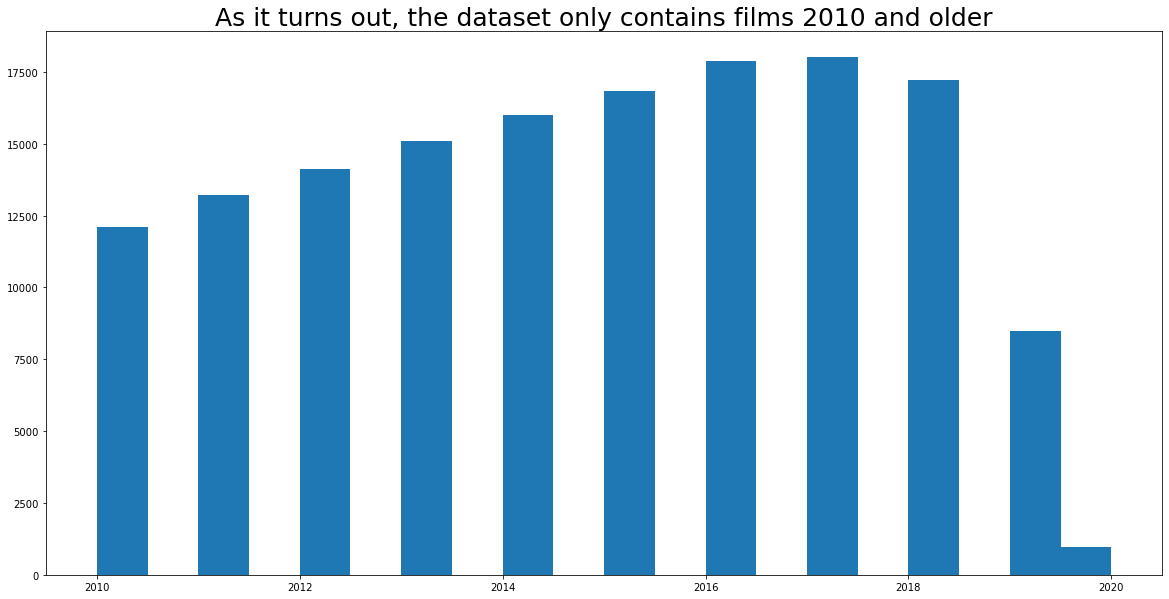

In [26]:
plt.hist(df_complete['start_year'].loc[df_complete['start_year']<=2020], bins=20)
plt.title('As it turns out, the dataset only contains films 2010 and older', fontsize=25)
plt.show()

#df_complete['start_year'].loc[df_complete['start_year']<=2020].value_counts()

# GRAPHICS FOR FINAL PRESENTATION: POPULARITY

Create graphs showing the most popular genres



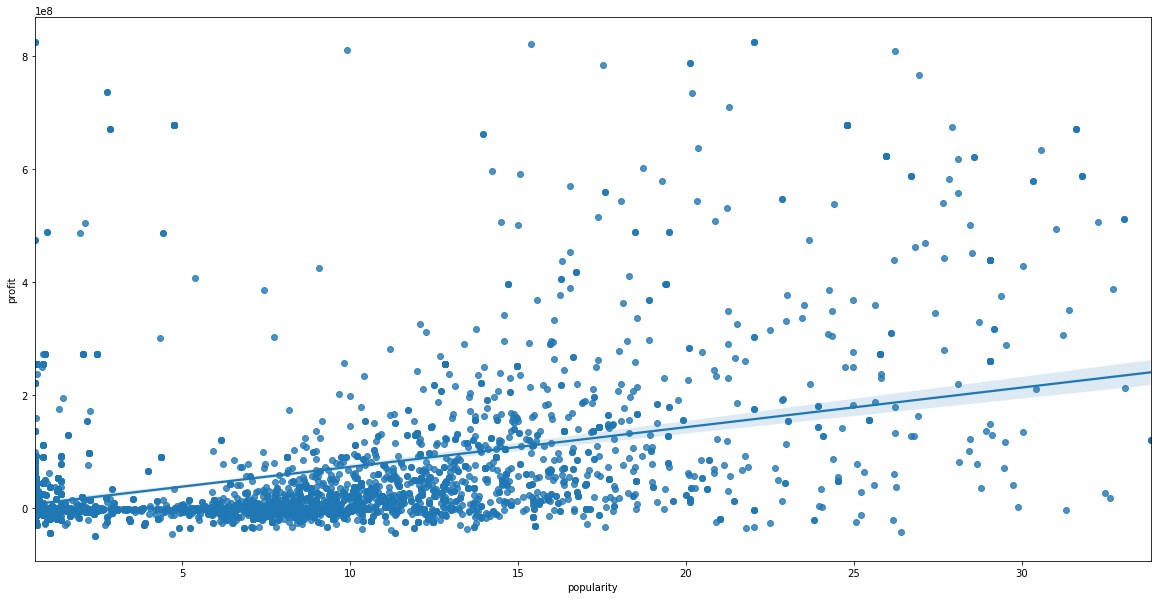

In [65]:
##### DOES POPULARITY LEAD TO PROFITABILITY?

CATEGORY = 'profit'
median = {}
for g in GENRES_FULL:
    temp = df_complete.loc[
                        (df_complete[g].isna() == False) &
                        (df_complete[CATEGORY].isna() == False) &
                        (df_complete[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
df_profit = pd.DataFrame(median.items())


CATEGORY = 'popularity'
median = {}
for g in GENRES_FULL:
    temp = df_complete.loc[
                        (df_complete[g].isna() == False) &
                        (df_complete[CATEGORY].isna() == False) &
                        (df_complete[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
df_popularity = pd.DataFrame(median.items())


q = '''SELECT * FROM df_profit JOIN df_popularity USING ('0');'''
df = pysqldf(q)
df.columns = ['genre', 'profit', 'popularity']


df = df_complete[['tconst', 'profit', 'popularity']].dropna().reset_index(drop=True)
QUANTILE = 0.01
df = df.loc[(df.profit >= df.profit.quantile(QUANTILE)) & (df.profit <= df.profit.quantile(1-QUANTILE))].copy()
df = df.loc[(df.popularity >= df.popularity.quantile(QUANTILE)) & (df.popularity <= df.popularity.quantile(1-QUANTILE))].copy()

x = df.popularity
y = df.profit
# use the function regplot to make a scatterplot
sns.regplot(x,y)
#sns.plt.show()
 
# Without regression fit:
#sns.regplot(x=df["sepal_length"], y=df["sepal_width"], fit_reg=False)
#sns.plt.show()


In [31]:
df_profit

,0,1
0,action,26800758.0
1,adventure,58702781.5
2,animation,110724600.0
3,biography,9403192.0
4,comedy,15852177.0
5,crime,2434356.0
6,documentary,6524293.0
7,drama,4152584.0
8,family,31059560.0
9,fantasy,36246127.5


,tconst,profit,popularity
1,tt0326592,965996.0,6.576
3,tt0359950,96861183.0,10.743
7,tt0383010,24052249.0,9.358
8,tt0393049,-300000.0,0.600
11,tt0403935,13257000.0,6.744
...,...,...,...
4192,tt9827712,-1982939.0,11.250
4193,tt9851050,76030660.0,10.993
4199,tt9899880,410511.0,8.964
4200,tt9906218,70720921.0,14.010
